# 데이터셋 

2013년 1월 부터 2015년 10월까지의 일간 데이터를 가지고 적합. 그후 2015년 11월의 매출을 예측 

트랙 1: 일간 데이터로 예측을해서 2015년 11월의 일간 데이터를 예측하고 합해서 월간 매출을 예상한다.

트랙 2: 처음부터 월간 매출로 더한뒤에 매달 월간 매출을 예측한다. 

In [542]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./../data/item_categories.csv
./../data/sales_train.csv
./../data/items_en.csv
./../data/shops.csv
./../data/sample_submission.csv
./../data/items.csv
./../data/item_categories_en.csv
./../data/test.csv
./../data/shops_en.csv


In [543]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


from warnings import filterwarnings
filterwarnings('ignore')

In [544]:
item_cats=pd.read_csv('./../data/item_categories.csv')
items = pd.read_csv('./../data/items.csv')
train=pd.read_csv('./../data/sales_train.csv')
shops = pd.read_csv('./../data/shops.csv')
test = pd.read_csv('./../data/test.csv')
sample_submission = pd.read_csv('./../data/sample_submission.csv')

In [546]:
# shops[shops.shop_id == 12]

,shop_name,shop_id
12,Интернет-магазин ЧС,12


In [302]:
# items[items.item_id == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [547]:
train[train.item_id == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [313]:
train[train.item_cnt_day >= 800]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,2015-01-15,24,12,20949,4.000000,1000.0
2909818,2015-10-28,33,12,11373,0.908714,2169.0


In [306]:
items[items.item_id == 20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


In [321]:
items[items.item_id == 11373]

len(train)

2935849

In [320]:
t  = train[train.shop_id == 12]
t.tail(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2919470,2015-10-21,33,12,3838,12999.0,2.0
2919471,2015-10-26,33,12,3838,12999.0,1.0
2919472,2015-10-30,33,12,3838,12999.0,1.0
2919473,2015-10-27,33,12,3839,6999.0,1.0
2919474,2015-10-19,33,12,3842,2799.0,1.0
2919475,2015-01-10,33,12,3862,139.0,1.0
2919476,2015-10-19,33,12,3862,139.0,1.0
2919477,2015-10-29,33,12,3862,139.0,1.0
2919478,2015-01-10,33,12,3868,999.0,1.0
2919479,2015-10-30,33,12,3756,7599.0,1.0


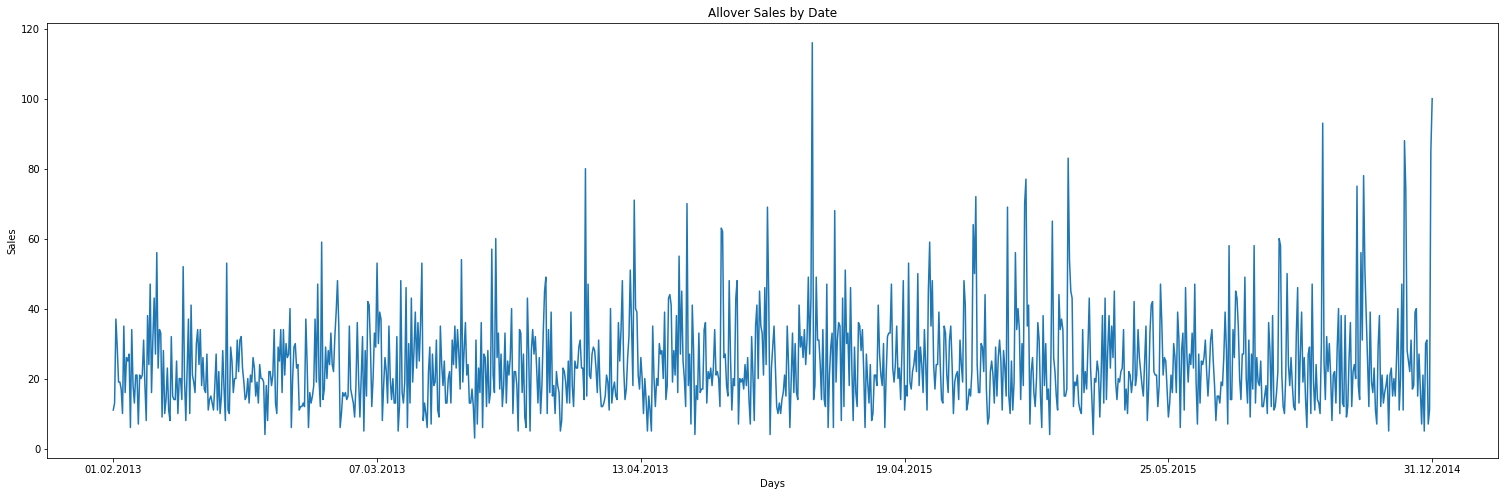

In [379]:
t  = train[train.shop_id == 10].groupby("date")['item_cnt_day'].sum()
t.plot(kind="line",
                     xlabel="Days",
                     ylabel="Sales",
                     title= "Allover Sales by Date",
                     figsize=(26,8));

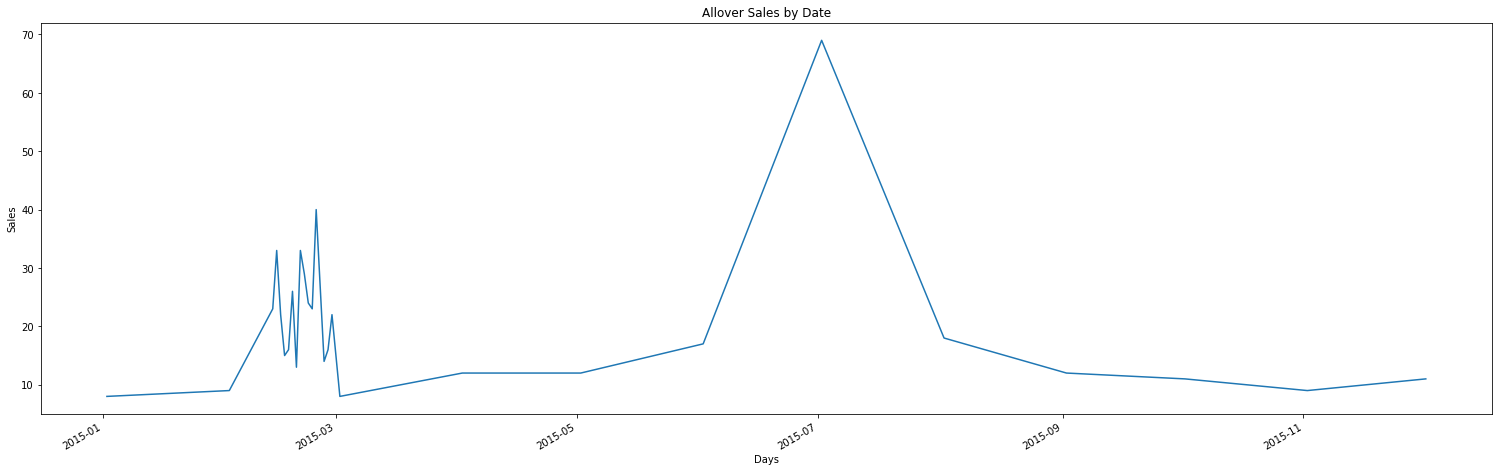

In [330]:
t  = train[train.shop_id == 11].groupby("date")['item_cnt_day'].sum()
t.plot(kind="line",
                     xlabel="Days",
                     ylabel="Sales",
                     title= "Allover Sales by Date",
                     figsize=(26,8));

In [309]:
train[train.item_id ==  11373]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
58323,2013-08-01,0,12,11373,1000.00,1.0
58324,2013-01-31,0,12,11373,97.80,5.0
176790,2013-01-02,1,12,11373,229.00,1.0
176791,2013-04-02,1,12,11373,130.00,1.0
302468,2013-03-29,2,12,11373,139.50,2.0
...,...,...,...,...,...,...
2909829,2015-07-10,33,12,11373,855.00,2.0
2909830,2015-06-10,33,12,11373,208.80,5.0
2909831,2015-05-10,33,12,11373,140.75,16.0
2909832,2015-02-10,33,12,11373,648.50,2.0


In [420]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [434]:
train=pd.read_csv('./../data/sales_train.csv')

In [435]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [437]:
train["date"]=pd.to_datetime(train["date"],format='%d.%m.%Y')

In [440]:
train["date"]

0         2013-01-02
1         2013-01-03
2         2013-01-05
3         2013-01-06
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-10-09
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-10-03
Name: date, Length: 2935849, dtype: datetime64[ns]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


각 일별로 grouping한 뒤에 item, "item_cnt_day"을 더한 뒤 나타내 보았습니다. 

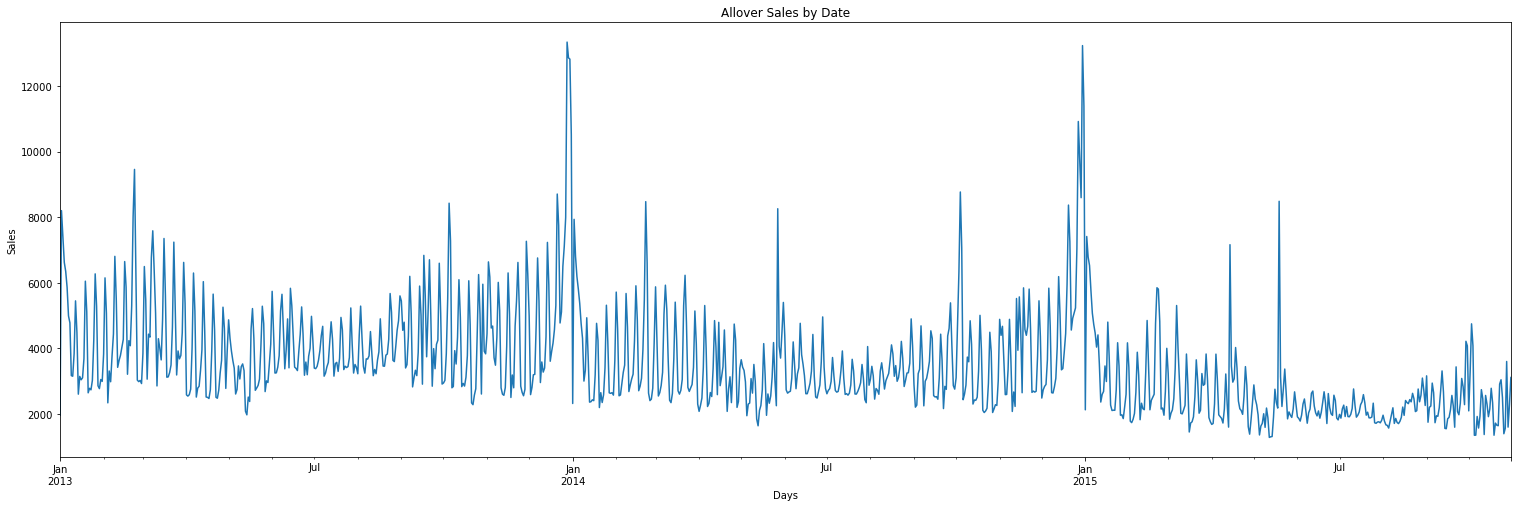

In [548]:
train["date"]=pd.to_datetime(train["date"],format='%d.%m.%Y')
allover_sales_by_date = train.groupby(["date"])["item_cnt_day"].sum()
allover_sales_by_date.plot(kind="line",
                     xlabel="Days",
                     ylabel="Sales",
                     title= "Allover Sales by Date",
                     figsize=(26,8));

In [442]:
allover_sales_by_date

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
               ...  
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Name: item_cnt_day, Length: 1034, dtype: float64

In [ ]:
저는 이 일간 데이터를 통해서 전체적인 plot의 형태를 살펴보고 싶습니다. 

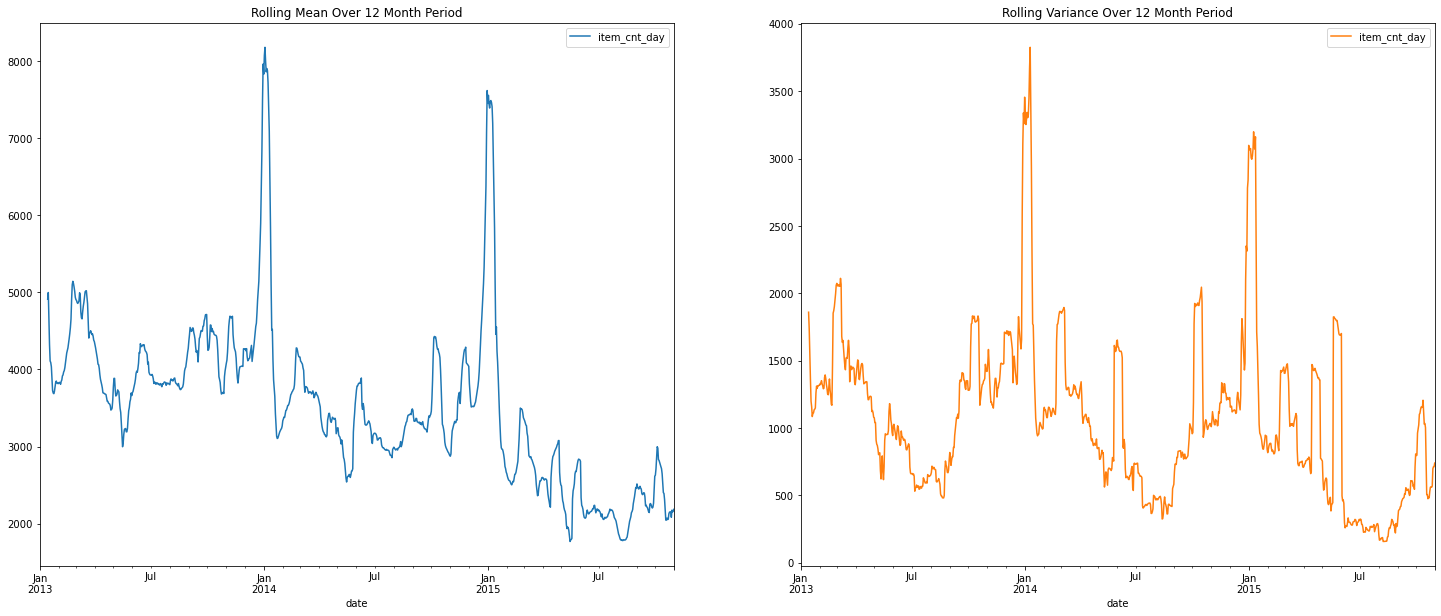

In [456]:
plt.subplot(121)
allover_sales_by_date.rolling(window = 14).mean().plot(figsize=(25,10), 
                                                 color="tab:blue", 
                                                 title="Rolling Mean Over 12 Month Period", 
                                                 legend = True);
plt.subplot(122)
allover_sales_by_date.rolling(window = 14).std().plot(color="tab:orange", 
                                                title="Rolling Variance Over 12 Month Period", 
                                                legend=True);

In [394]:
allover_sales_by_date.tail(40)

date
30.05.2015     2665.0
30.06.2013     4227.0
30.06.2014     2768.0
30.06.2015     1809.0
30.07.2013     3501.0
30.07.2014     4048.0
30.07.2015     1720.0
30.08.2013     4838.0
30.08.2014     4893.0
30.08.2015     2719.0
30.09.2013     2904.0
30.09.2014     2749.0
30.09.2015     4068.0
30.10.2013     3904.0
30.10.2014     2250.0
30.10.2015     2274.0
30.11.2013     6268.0
30.11.2014     4349.0
30.12.2013    12823.0
30.12.2014    13236.0
31.01.2013     2986.0
31.01.2014     3614.0
31.01.2015     4162.0
31.03.2013     5369.0
31.03.2014     2292.0
31.03.2015     1755.0
31.05.2013     4121.0
31.05.2014     5395.0
31.05.2015     2283.0
31.07.2013     3413.0
31.07.2014     2868.0
31.07.2015     1796.0
31.08.2013     5595.0
31.08.2014     4071.0
31.08.2015     2250.0
31.10.2013     3826.0
31.10.2014     3014.0
31.10.2015     3104.0
31.12.2013    10514.0
31.12.2014    11394.0
Name: item_cnt_day, dtype: float64


2주간의 평균,과 분산을 통해 확실한 seasonality과 분산의 변동을 확인할 수 있었습니다.                  
일간을 통해서 확인할 수 있었던 점은 2015년 11월의 분산이 오히려 작아지는 영향이 있닫는 것입니다.                 
이는 월간 데이터를 통해서는 확인할 수 없었던 측면입니다.           


이때 일간 데이터이기때문에 seasonality를 어떻게 놓을지에 대해서 고민하게 되었습니다.              
월마다 seaonalirty를 30일로 잡으면 각 달안에서의 seasonality을 잡아낼수있습니다.             
그러나 연말에 상승하는 sales은 trend로 잡히게 되고 
이는 우리 분석에 있어서 중대한 영향을 미치는 11월, 12월에 상승하는 sales를  잡지 못하게 될것이기 떄문입니다.

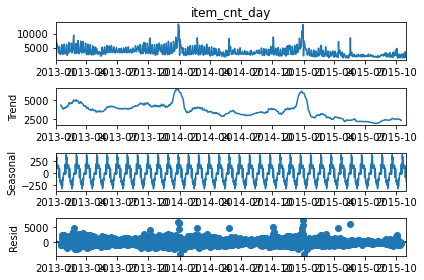

In [444]:
from statsmodels.tsa.seasonal import seasonal_decompose # seasonality 주기 30 

decompose_result = seasonal_decompose(allover_sales_by_date, freq= 30, model="additive")
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();


이때 일간 데이터이기때문에 seasonality를 어떻게 놓을지에 대해서 고민하게 되었습니다.           
월마다 seaonalirty를 30일로 잡으면 각 달안에서의 seaonalirty을 잡아낼수있습니다.                            
그러나 연말에 상승하는 매출은 trend로 잡히게 됩니다.              
이는 우리 분석에 있어서 중대한 영향을 미치는 월말 매출급등을 잡지 못하게 될것이기 떄문입니다.

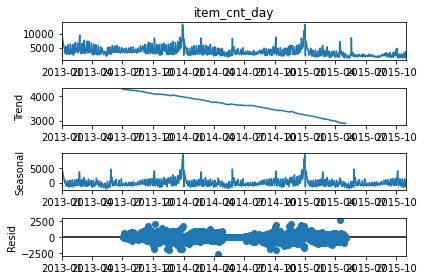

In [445]:
from statsmodels.tsa.seasonal import seasonal_decompose #계절성 주기 365

decompose_result = seasonal_decompose(allover_sales_by_date, freq= 365 , model="additive")
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

반대로 계절성 주기를 365로 잡으면 위와 같이 계산할 수 있습니다.        
매년안에서의 계절성을 잡아낼수 있게 됩니다.             
그러나 우리의 데이터가 2013,2014,2015년 일부의 데이터이기때문에                 

seasonality를 계산함에 있어서 365로 계산했을때 각 365번의 주기가 2번, 3번밖에 돌지않습니다.         
즉 겨우 2번, 3번의 기회로 seasonaltiy를 계산하게 됩니다. 이는 sample이 매우 적다는것을 의미하고 

즉 우리가 추정한 seasoanlity의 추정이 상대적으로 안정되지않은 값을 가지게 된다는 단점이 있습니다. 

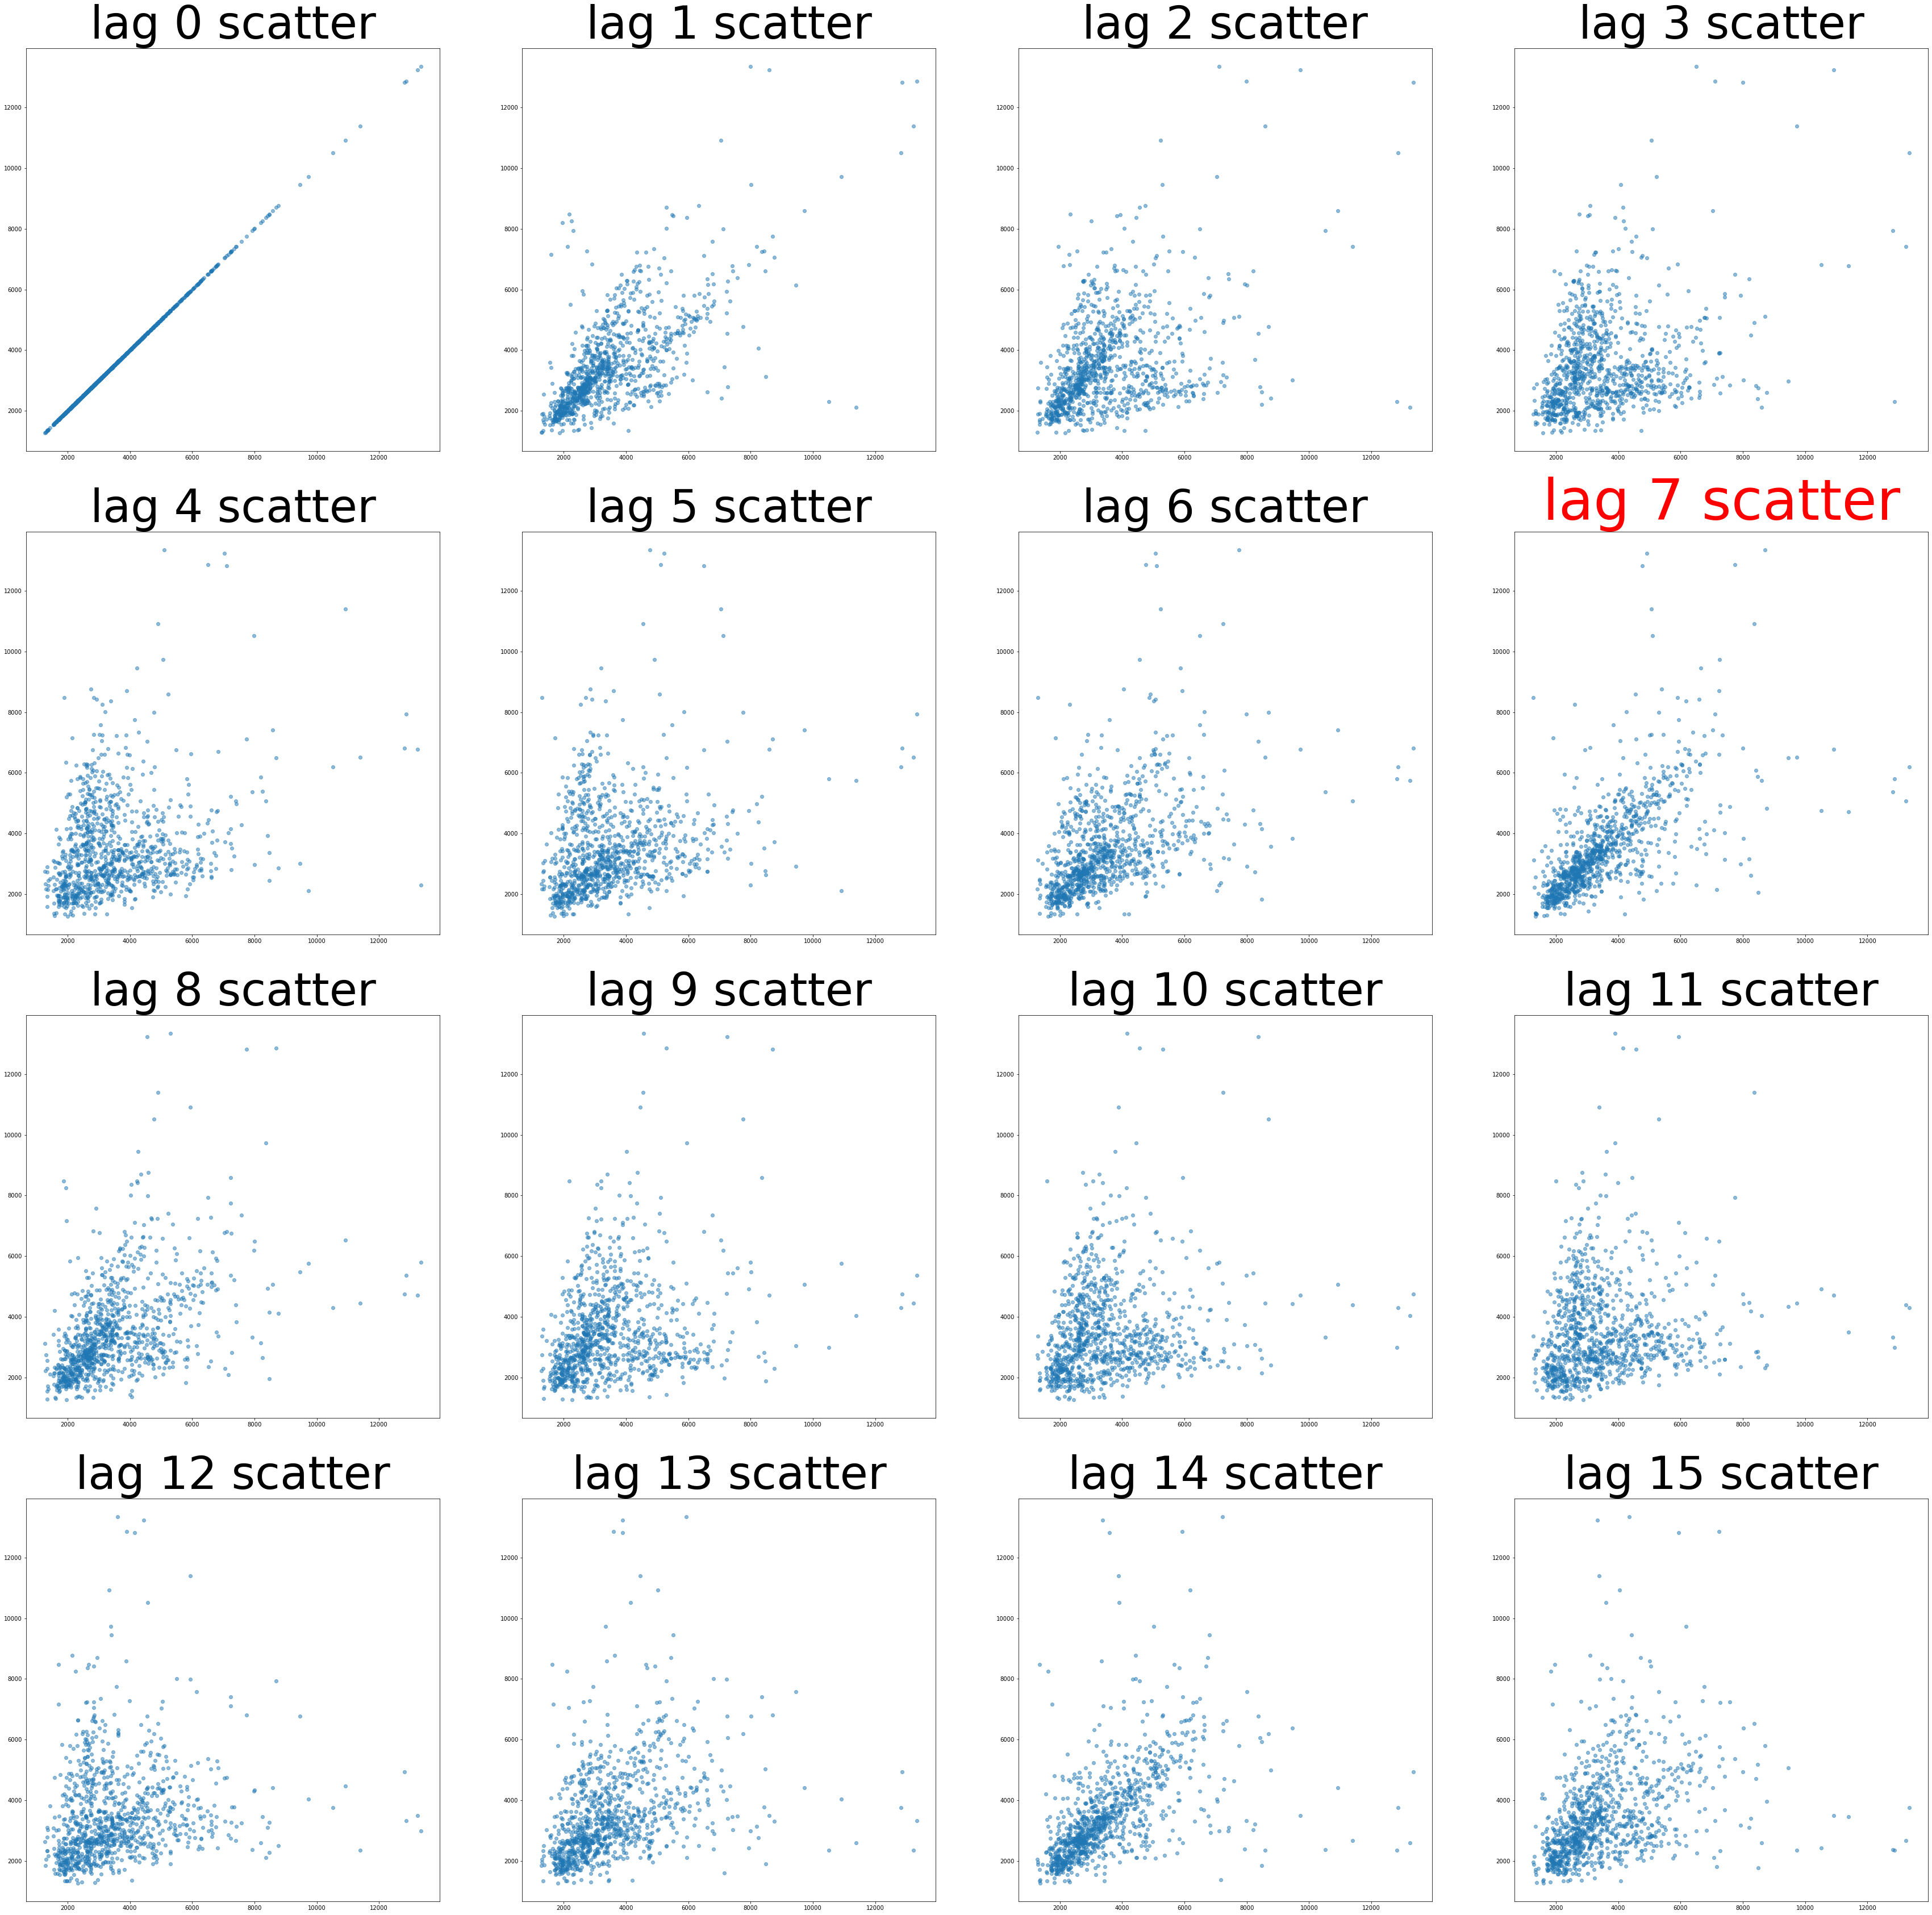

In [539]:
fig, ax = plt.subplots(4, 4, figsize=(60, 60))
for k in range(0,16):
    i,j = divmod(0+k,4)
    ax[0+i,0+j].scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)], alpha = 0.5)
    if k == 7:
        ax[0+i,0+j].set_title("lag " + str(k) + " scatter",fontsize= 100, c = "r" )
    else:    
        ax[0+i,0+j].set_title("lag " + str(k) + " scatter",fontsize= 80 )
    

plt.show()

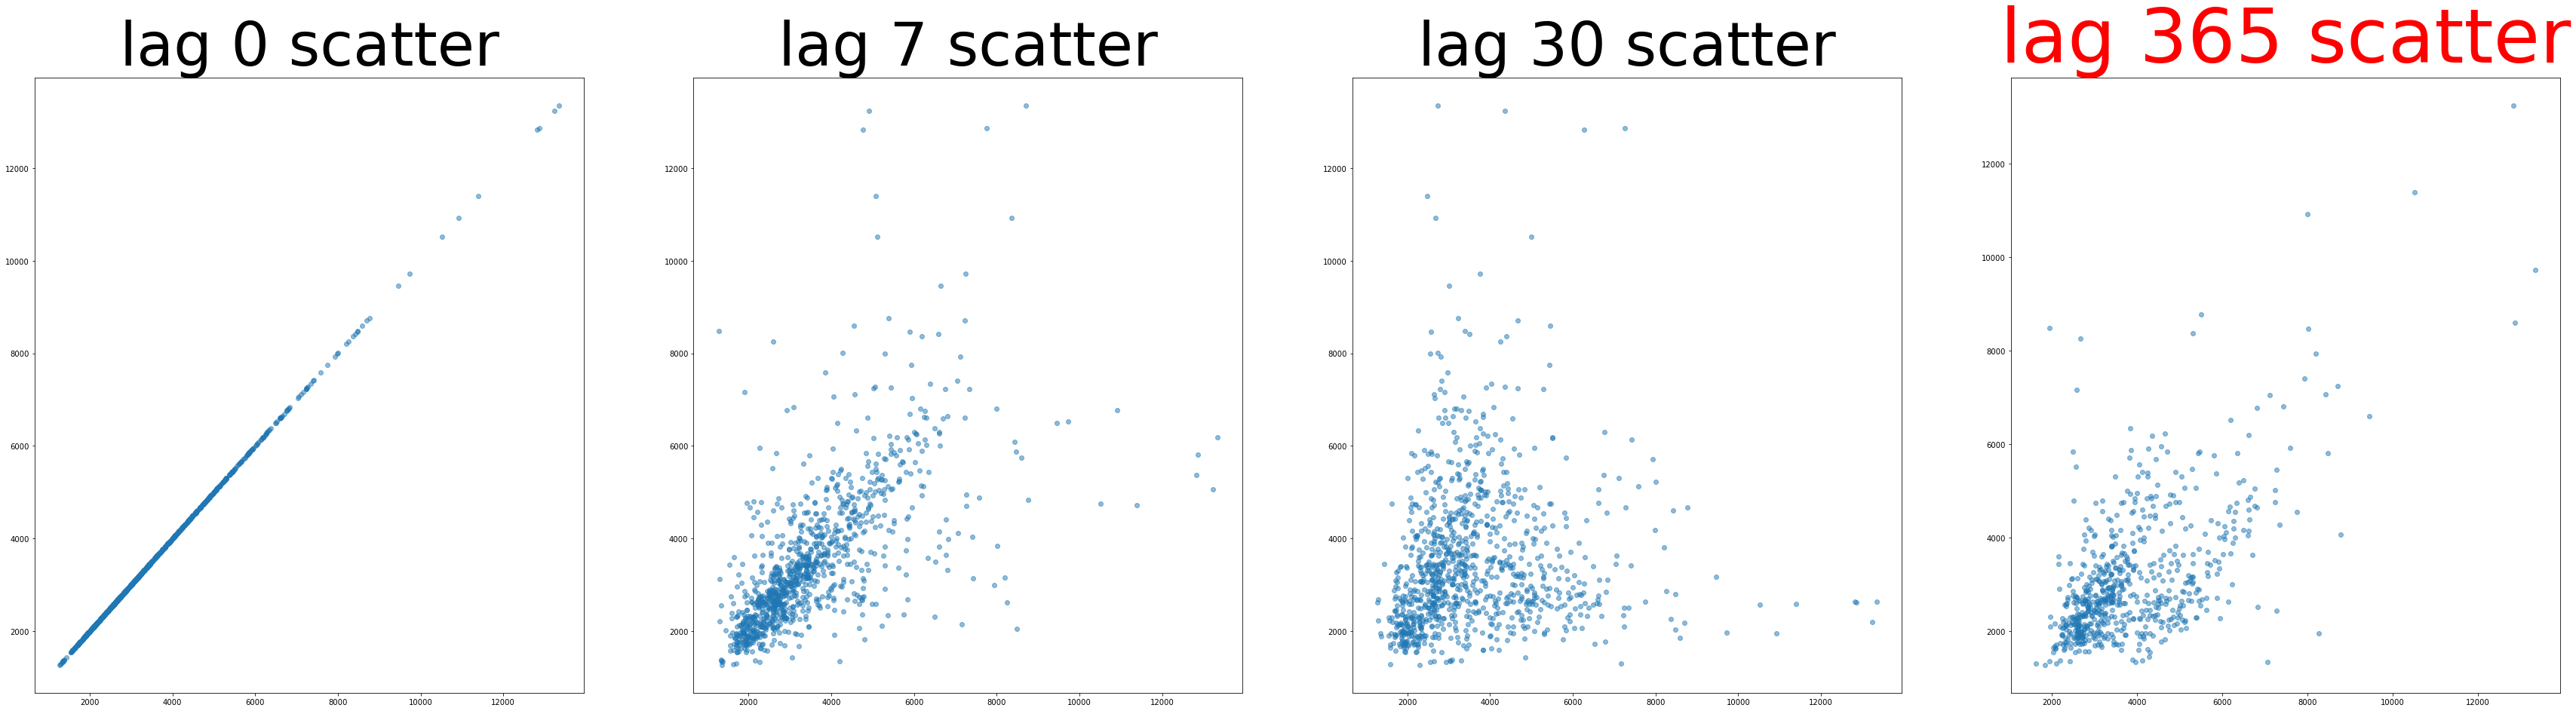

In [541]:
fig, ax = plt.subplots(1, 4, figsize=(60, 15))
i = 0 
for k in [0,7,30,365]:
    ax[0+i].scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)], alpha = 0.5)
    if k == 365:
        ax[0+i].set_title("lag " + str(k) + " scatter",fontsize= 100, c = "r" )
    else:    
        ax[0+i].set_title("lag " + str(k) + " scatter",fontsize= 80 )
    
    i += 1 
plt.show()

In [ ]:
여기서 365의 scatter르 더 자세히 살펴보도록 하겠다. 

In [399]:
allover_sales_by_date[:100]

date
01.01.2013    1951.0
01.01.2014    2310.0
01.01.2015    2117.0
01.02.2013    3817.0
01.02.2014    5711.0
               ...  
03.10.2013    3828.0
03.10.2014    6330.0
03.10.2015    4742.0
03.11.2013    6170.0
03.11.2014    4666.0
Name: item_cnt_day, Length: 100, dtype: float64

In [384]:
len(allover_sales_by_date)

1034

In [387]:
k

365

In [479]:
allover_sales_by_date[(273):(304)]

date
2013-10-01    2935.0
2013-10-02    3015.0
2013-10-03    3828.0
2013-10-04    5506.0
2013-10-05    8425.0
2013-10-06    7270.0
2013-10-07    2790.0
2013-10-08    2829.0
2013-10-09    3923.0
2013-10-10    3515.0
2013-10-11    4330.0
2013-10-12    6089.0
2013-10-13    4943.0
2013-10-14    2825.0
2013-10-15    2923.0
2013-10-16    2842.0
2013-10-17    3110.0
2013-10-18    3772.0
2013-10-19    6056.0
2013-10-20    4717.0
2013-10-21    2328.0
2013-10-22    2274.0
2013-10-23    2567.0
2013-10-24    2761.0
2013-10-25    4416.0
2013-10-26    6246.0
2013-10-27    5026.0
2013-10-28    2599.0
2013-10-29    5951.0
2013-10-30    3904.0
2013-10-31    3826.0
Name: item_cnt_day, dtype: float64

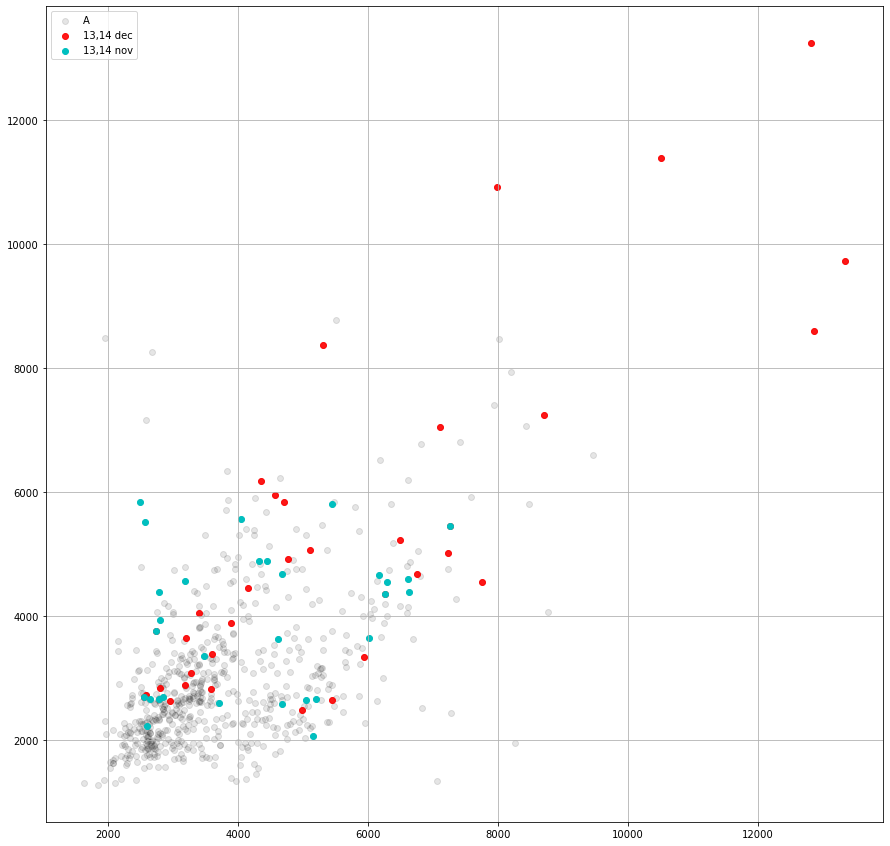

In [507]:
fig = plt.figure(figsize=(15,15)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
# ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)])
ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)],label='A',c = 'k', alpha = 0.1) ## 선그래프 생성
# ax.scatter(allover_sales_by_date[0:30],allover_sales_by_date[(0+k):(30+k)],label='Early',c= 'g', alpha = 0.05) ## 선그래프 생성

ax.scatter(allover_sales_by_date[330:365],allover_sales_by_date[(330+k):(365+k)],label='13,14 dec',c = 'r',alpha = 0.9) ## 선그래프 생성
ax.scatter(allover_sales_by_date[304:334],allover_sales_by_date[(304+k):(334+k)],label='13,14 nov',c = 'c',alpha = 1) ## 선그래프 생성



plt.grid()
plt.legend()

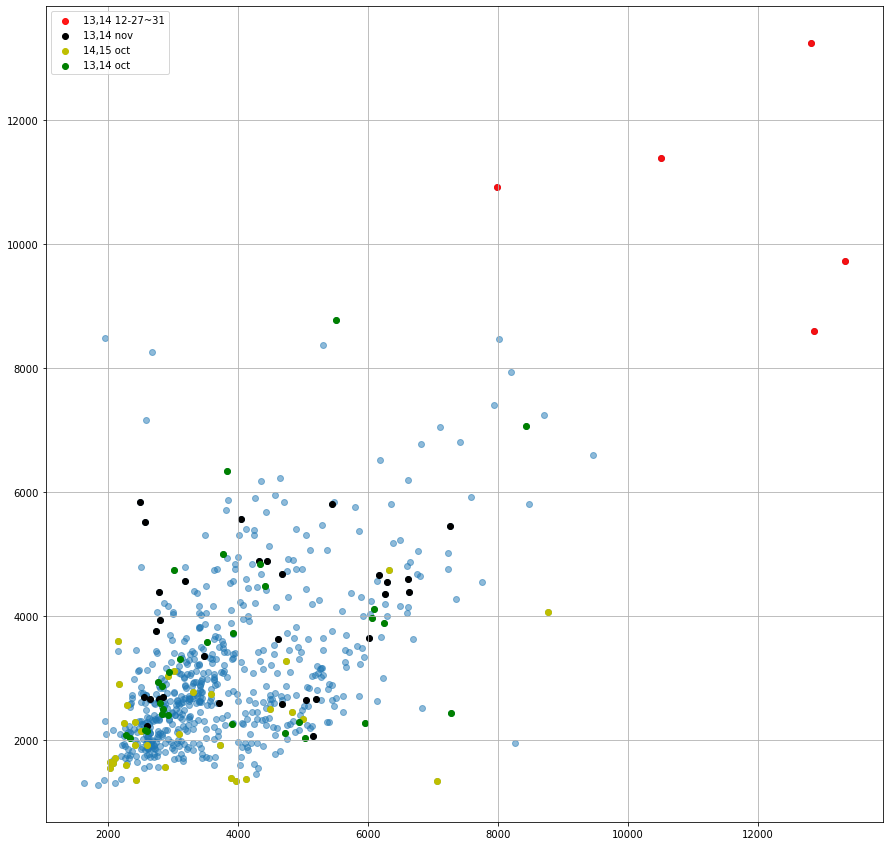

In [525]:
fig = plt.figure(figsize=(15,15)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
# ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)])
ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)],alpha = 0.5) ## 선그래프 생성
# ax.scatter(allover_sales_by_date[0:30],allover_sales_by_date[(0+k):(30+k)],label='Early',c= 'g', alpha = 0.05) ## 선그래프 생성
ax.scatter(allover_sales_by_date[360:365],allover_sales_by_date[(360+k):(365+k)],label='13,14 12-27~31',c = 'r',alpha = 0.9) ## 선그래프 생성
ax.scatter(allover_sales_by_date[304:334],allover_sales_by_date[(304+k):(334+k)],label='13,14 nov',c = 'k',alpha = 1) ## 선그래프 생성
# ax.scatter(allover_sales_by_date[304:334],allover_sales_by_date[(304+k):(334+k)],label='14,15 nov',c = 'k',alpha = 1) ## 선그래프 생성
ax.scatter(allover_sales_by_date[638:669],allover_sales_by_date[(638+k):(669+k)],label='14,15 oct',c = 'y',alpha = 1) ## 선그래프 생성
ax.scatter(allover_sales_by_date[273:303],allover_sales_by_date[(273+k):(303+k)],label='13,14 oct',c = 'g',alpha = 1) ## 선그래프 생성


plt.grid()
plt.legend()

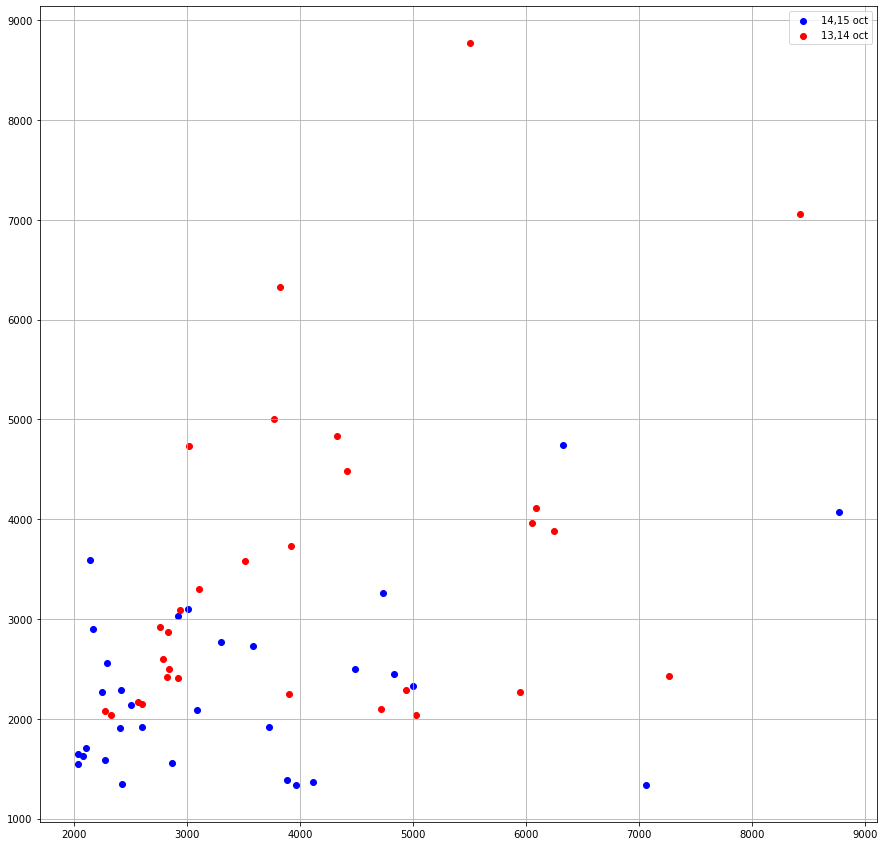

In [529]:
fig = plt.figure(figsize=(15,15)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
ax.scatter(allover_sales_by_date[638:669],allover_sales_by_date[(638+k):(669+k)],label='14,15 oct',c = 'b',alpha = 1) ## 선그래프 생성
ax.scatter(allover_sales_by_date[273:303],allover_sales_by_date[(273+k):(303+k)],label='13,14 oct',c = 'r',alpha = 1) ## 선그래프 생성


plt.grid()
plt.legend()

상대적으로 최신인 14년,15년의 oct끼리 선형의 상관성이 깨지고 있음을 확인할수있다.(14년은 sales가 높지만 15년은 낮음)
이는 점차 낮아지고 있는 trend의 영향이 미치는 것으로 해석 가능하다.

In [515]:
allover_sales_by_date[304:334]

date
2013-11-01    4439.0
2013-11-02    6633.0
2013-11-03    6170.0
2013-11-04    4614.0
2013-11-05    4674.0
2013-11-06    3708.0
2013-11-07    3479.0
2013-11-08    4320.0
2013-11-09    6007.0
2013-11-10    5150.0
2013-11-11    2787.0
2013-11-12    2595.0
2013-11-13    2560.0
2013-11-14    2795.0
2013-11-15    4045.0
2013-11-16    6296.0
2013-11-17    5042.0
2013-11-18    2494.0
2013-11-19    3180.0
2013-11-20    2789.0
2013-11-21    4673.0
2013-11-22    5438.0
2013-11-23    6616.0
2013-11-24    5201.0
2013-11-25    2838.0
2013-11-26    2648.0
2013-11-27    2546.0
2013-11-28    2742.0
2013-11-29    7262.0
2013-11-30    6268.0
Name: item_cnt_day, dtype: float64

In [519]:
allover_sales_by_date[273:303]

date
2013-10-01    2935.0
2013-10-02    3015.0
2013-10-03    3828.0
2013-10-04    5506.0
2013-10-05    8425.0
2013-10-06    7270.0
2013-10-07    2790.0
2013-10-08    2829.0
2013-10-09    3923.0
2013-10-10    3515.0
2013-10-11    4330.0
2013-10-12    6089.0
2013-10-13    4943.0
2013-10-14    2825.0
2013-10-15    2923.0
2013-10-16    2842.0
2013-10-17    3110.0
2013-10-18    3772.0
2013-10-19    6056.0
2013-10-20    4717.0
2013-10-21    2328.0
2013-10-22    2274.0
2013-10-23    2567.0
2013-10-24    2761.0
2013-10-25    4416.0
2013-10-26    6246.0
2013-10-27    5026.0
2013-10-28    2599.0
2013-10-29    5951.0
2013-10-30    3904.0
Name: item_cnt_day, dtype: float64

In [449]:
allover_sales_by_date[360:365]

date
2013-12-27     7991.0
2013-12-28    13343.0
2013-12-29    12863.0
2013-12-30    12823.0
2013-12-31    10514.0
Name: item_cnt_day, dtype: float64

In [459]:
allover_sales_by_date[304:334]

date
2013-11-01    4439.0
2013-11-02    6633.0
2013-11-03    6170.0
2013-11-04    4614.0
2013-11-05    4674.0
2013-11-06    3708.0
2013-11-07    3479.0
2013-11-08    4320.0
2013-11-09    6007.0
2013-11-10    5150.0
2013-11-11    2787.0
2013-11-12    2595.0
2013-11-13    2560.0
2013-11-14    2795.0
2013-11-15    4045.0
2013-11-16    6296.0
2013-11-17    5042.0
2013-11-18    2494.0
2013-11-19    3180.0
2013-11-20    2789.0
2013-11-21    4673.0
2013-11-22    5438.0
2013-11-23    6616.0
2013-11-24    5201.0
2013-11-25    2838.0
2013-11-26    2648.0
2013-11-27    2546.0
2013-11-28    2742.0
2013-11-29    7262.0
2013-11-30    6268.0
Name: item_cnt_day, dtype: float64

In [466]:
allover_sales_by_date[(669):(709)]

date
2014-11-01    4879.0
2014-11-02    4390.0
2014-11-03    4666.0
2014-11-04    3632.0
2014-11-05    2581.0
2014-11-06    2586.0
2014-11-07    3347.0
2014-11-08    4879.0
2014-11-09    3644.0
2014-11-10    2067.0
2014-11-11    2661.0
2014-11-12    2221.0
2014-11-13    5515.0
2014-11-14    3935.0
2014-11-15    5564.0
2014-11-16    4547.0
2014-11-17    2638.0
2014-11-18    5840.0
2014-11-19    4568.0
2014-11-20    4392.0
2014-11-21    4668.0
2014-11-22    5803.0
2014-11-23    4588.0
2014-11-24    2650.0
2014-11-25    2688.0
2014-11-26    2658.0
2014-11-27    2685.0
2014-11-28    3759.0
2014-11-29    5445.0
2014-11-30    4349.0
2014-12-01    2476.0
2014-12-02    2724.0
2014-12-03    2833.0
2014-12-04    2891.0
2014-12-05    3642.0
2014-12-06    5831.0
2014-12-07    4679.0
2014-12-08    2641.0
2014-12-09    2630.0
2014-12-10    2820.0
Name: item_cnt_day, dtype: float64

In [512]:
allover_sales_by_date[(638+k):(669+k)]

date
2015-10-01    2085.0
2015-10-02    3265.0
2015-10-03    4742.0
2015-10-04    4069.0
2015-10-05    1340.0
2015-10-06    1343.0
2015-10-07    1914.0
2015-10-08    1561.0
2015-10-09    1922.0
2015-10-10    2732.0
2015-10-11    2454.0
2015-10-12    1363.0
2015-10-13    2556.0
2015-10-14    2294.0
2015-10-15    1908.0
2015-10-16    2143.0
2015-10-17    2775.0
2015-10-18    2330.0
2015-10-19    1341.0
2015-10-20    1711.0
2015-10-21    1647.0
2015-10-22    1632.0
2015-10-23    2901.0
2015-10-24    3035.0
2015-10-25    2495.0
2015-10-26    1387.0
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Name: item_cnt_day, dtype: float64

In [472]:
allover_sales_by_date[(638):(668)]

date
2014-10-01    3093.0
2014-10-02    4735.0
2014-10-03    6330.0
2014-10-04    8767.0
2014-10-05    7060.0
2014-10-06    2425.0
2014-10-07    2601.0
2014-10-08    2871.0
2014-10-09    3727.0
2014-10-10    3583.0
2014-10-11    4835.0
2014-10-12    4115.0
2014-10-13    2293.0
2014-10-14    2417.0
2014-10-15    2407.0
2014-10-16    2501.0
2014-10-17    3302.0
2014-10-18    5001.0
2014-10-19    3962.0
2014-10-20    2103.0
2014-10-21    2034.0
2014-10-22    2081.0
2014-10-23    2165.0
2014-10-24    2925.0
2014-10-25    4485.0
2014-10-26    3886.0
2014-10-27    2035.0
2014-10-28    2146.0
2014-10-29    2273.0
2014-10-30    2250.0
Name: item_cnt_day, dtype: float64

In [361]:
allover_sales_by_date

date
2013-01-01    1951.0
2013-01-02    3817.0
2013-01-03    3846.0
2013-01-04    2574.0
2013-01-05    4863.0
               ...  
2015-12-06    2690.0
2015-12-07    2263.0
2015-12-08    1696.0
2015-12-09    3304.0
2015-12-10    1363.0
Name: item_cnt_day, Length: 1034, dtype: float64

In [243]:
allover_sales_by_date_ri = allover_sales_by_date.reset_index()

In [244]:
allover_sales_by_date_ri["date"]=pd.to_datetime(allover_sales_by_date_ri["date"])

In [245]:
allover_sales_by_date_ri

,date,item_cnt_day
0,2013-01-01,1951.0
1,2013-01-02,3817.0
2,2013-01-03,3846.0
3,2013-01-04,2574.0
4,2013-01-05,4863.0
...,...,...
1029,2015-12-06,2690.0
1030,2015-12-07,2263.0
1031,2015-12-08,1696.0
1032,2015-12-09,3304.0


In [246]:
import datetime as dt
allover_sales_by_date_ri['day'] = allover_sales_by_date_ri['date'].dt.day
allover_sales_by_date_ri['month'] = allover_sales_by_date_ri["date"].dt.month
allover_sales_by_date_ri['year'] = allover_sales_by_date_ri["date"].dt.year

In [366]:
allover_sales_by_date_ri.tail(40)

,date,item_cnt_day,day,month,year
994,2015-10-10,2732.0,10,10,2015
995,2015-10-13,2556.0,13,10,2015
996,2015-10-14,2294.0,14,10,2015
997,2015-10-15,1908.0,15,10,2015
998,2015-10-16,2143.0,16,10,2015
999,2015-10-17,2775.0,17,10,2015
1000,2015-10-18,2330.0,18,10,2015
1001,2015-10-19,1341.0,19,10,2015
1002,2015-10-20,1711.0,20,10,2015
1003,2015-10-21,1647.0,21,10,2015


In [ ]:
allover_sales_by_date_ri['year'] 

In [269]:
allover_sales_by_date_ri[allover_sales_by_date_ri.month == 1].loc[:,'item_cnt_day']

0      1951.0
1      3817.0
2      3846.0
3      2574.0
4      4863.0
        ...  
754    1966.0
755    1849.0
756    2204.0
757    2590.0
758    4162.0
Name: item_cnt_day, Length: 91, dtype: float64

In [272]:
allover_sales_by_date_ri[allover_sales_by_date_ri.month == 1].loc[:,'item_cnt_day'][758]

4162.0

In [261]:
allover_sales_by_date[1]

date
2013-01-01    1951.0
2013-01-02    3817.0
2013-01-03    3846.0
2013-01-04    2574.0
2013-01-05    4863.0
               ...  
2015-12-06    2690.0
2015-12-07    2263.0
2015-12-08    1696.0
2015-12-09    3304.0
2015-12-10    1363.0
Name: item_cnt_day, Length: 1034, dtype: float64

In [280]:
allover_sales_by_date_ri[allover_sales_by_date_ri.month == 1].loc[:,'item_cnt_day'][0:(len(allover_sales_by_date)-k)]

0      1951.0
1      3817.0
2      3846.0
3      2574.0
4      4863.0
        ...  
754    1966.0
755    1849.0
756    2204.0
757    2590.0
758    4162.0
Name: item_cnt_day, Length: 91, dtype: float64

In [293]:
len(allover_sales_by_date)-k

669

In [291]:
allover_sales_by_date_ri[allover_sales_by_date_ri.month == 1].loc[:,'item_cnt_day']

0      1951.0
1      3817.0
2      3846.0
3      2574.0
4      4863.0
        ...  
754    1966.0
755    1849.0
756    2204.0
757    2590.0
758    4162.0
Name: item_cnt_day, Length: 91, dtype: float64

In [286]:
print(k)
len(allover_sales_by_date)

365


1034

In [292]:
allover_sales_by_date_ri[allover_sales_by_date_ri.month == 1].loc[:,'item_cnt_day'][(0+k):]

2310.0

ValueError: x and y must be the same size

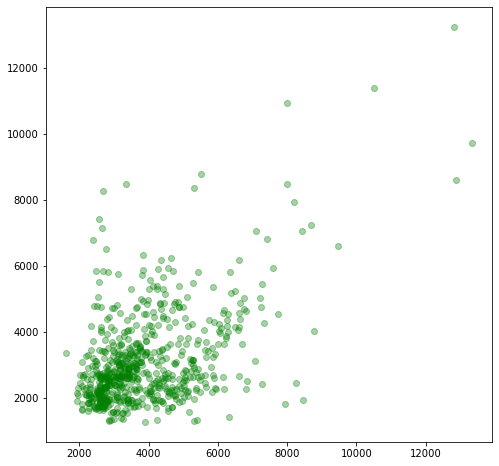

In [274]:
k = 365
fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
# ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)])
ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)],label='A',c = 'g',alpha = 0.35) ## 선그래프 생성

ax.scatter(allover_sales_by_date_ri[allover_sales_by_date_ri.month == 1].loc[:,'item_cnt_day'][0:(len(allover_sales_by_date)-k)],allover_sales_by_date_ri[allover_sales_by_date_ri.month == 1].loc[:,'item_cnt_day'][(0+k):len(allover_sales_by_date)],label='A',c = 'g',alpha = 0.35) ## 선그래프 생성

plt.grid()
plt.legend()

ValueError: x and y must be the same size

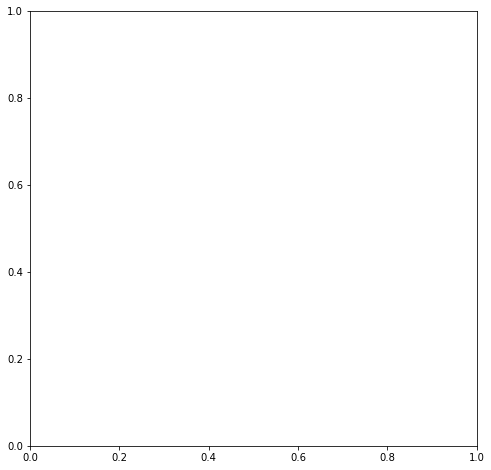

In [203]:
fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
# ax.scatter(allover_sales_by_date[0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)])
ax.scatter(allover_sales_by_date[allover_sales_by_date['month'] == 2][0:(len(allover_sales_by_date)-k)],allover_sales_by_date[(0+k):len(allover_sales_by_date)],label='A',c = 'g',alpha = 0.1) ## 선그래프 생성
# plt.grid()
# plt.legend()

In [204]:
allover_sales_by_date[allover_sales_by_date['month'] == 2]

,index,date,item_cnt_day,day,month,year
31,31,2013-02-01,8198.0,1,2,2013
32,32,2013-02-02,6145.0,2,2,2013
33,33,2013-02-03,6491.0,3,2,2013
34,34,2013-02-04,2536.0,4,2,2013
35,35,2013-02-05,4301.0,5,2,2013
...,...,...,...,...,...,...
780,780,2015-02-24,2142.0,24,2,2015
781,781,2015-02-25,2172.0,25,2,2015
782,782,2015-02-26,1952.0,26,2,2015
783,783,2015-02-27,2677.0,27,2,2015


In [177]:
allover_sales_by_date.reset_index()[allover_sales_by_date.reset_index()["date"] == "2015-04-03"]

,date,item_cnt_day
816,2015-04-03,2116.0


In [170]:
allover_sales_by_date["date"]

KeyError: 'date'